In [1]:
from sklearn import ensemble, cross_validation, learning_curve, metrics
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score

from sklearn.model_selection import GroupKFold

from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from scipy.stats.kde import gaussian_kde
from scipy.optimize import brentq

import itertools

C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are mov

In [2]:
triplexes = pd.read_csv('basetriples3.csv', header=0, sep='\t')

In [3]:
triplexes.head()

,pdb_chain,type,dssrs,bps,dists,same12,local12,longrange12,same23,local23,...,h3p5,b3p5,i3p5,j3p5,lc3p5,li3p5,lp3p5,fl3p5,fed3p5,istriple
0,1b23.cif1_R,123,R.4SU.8.R.A.13.R.A.14.,-_-_tWH,9.57_5.75_10.04,0,0,1,1,0,...,1,0,0,0,1,0,0,9,2,0
1,1b23.cif1_R,123,R.4SU.8.R.A.13.R.A.46.,-_-_cSS,9.57_12.47_4.86,0,0,1,0,0,...,0,0,0,0,0,0,0,5,1,0
2,1b23.cif1_R,123,R.A.13.R.G.15.R.A.46.,-_-_-,10.88_14.44_12.47,1,0,0,0,0,...,0,0,0,0,0,0,0,5,1,0
3,1b23.cif1_R,110,R.A.14.R.A.46.R.G.52.,t.W_-_-,12.76_21.27_28.07,0,0,1,0,1,...,1,0,0,0,1,0,0,7,3,0
4,1b23.cif1_R,110,R.A.9.R.A.13.R.G.30.,tHW_-_-,11.7_28.0_21.92,0,0,1,0,0,...,1,0,0,0,1,0,0,9,4,0


In [3]:
### !!!!! необходимые данные

triplexes_data = triplexes.iloc[:, 5:475]
triplexes_target = triplexes.iloc[:, 476]

In [4]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap="YlGnBu"):  #"YlGnBu" plt.cm.gray_r
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    print("CONFUSION MATRIX")
    print(df_confusion)
    a = itertools.product(range(df_confusion.shape[0]), range(df_confusion.shape[1]))
    for i, j in itertools.product(range(df_confusion.shape[0]), range(df_confusion.shape[1])):
        if i == 2:
            i_ = 'All'
        else:
            i_ = i
        if j == 2:
            j_ = 'All'
        else:
            j_ = j
        plt.text(i, j, df_confusion[i_][j_], horizontalalignment="center", color='black')
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    plt.show()
    
    
    
def probability_density(y_prob, y):
    
    kde1 = gaussian_kde(y_prob[y == 1])
    kde2 = gaussian_kde(y_prob[y == 0])
    
    x1 = np.linspace(np.min(y_prob[y == 1]),np.max(y_prob[y == 1]),500)
    x2 = np.linspace(np.min(y_prob[y == 0]),np.max(y_prob[y == 0]),500)
    
    try:
        treshold = brentq(lambda x : kde1(x) - kde2(x), x2[np.argmax(kde1(x1))], x1[np.argmax(kde2(x2))])
    except ValueError:
        treshold = 0.5
        
    plt.fill_between(x1,kde1(x1),0, color='darkblue', alpha = 0.5, label = 'Triplexes')
    plt.fill_between(x2,kde2(x2), 0, color='darkgrey', alpha = 0.5, label = 'Non-triplexes')
    plt.axvline(x1[np.argmax(kde1(x1))], color='black', linestyle='--', alpha = 0.5)
    plt.axvline(x2[np.argmax(kde2(x2))], color='black', linestyle='--', alpha = 0.5)
    plt.axvline(treshold, color='black', linestyle='-.', alpha = 0.7, label = str(round(treshold,2)))
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title('Probability Distributions')
    plt.xlabel('Probabilities')
    plt.show()


In [5]:
#используемая модель
rf_classifier_cv = ensemble.RandomForestClassifier(n_estimators=50, max_depth=10, random_state=1)

TEST_GROUPS Counter({'3j7q.cif1_5': 1316, '3j79.cif1_A': 965, '3j7p.cif1_S2': 765, '6ha1.cif1_a': 644, '6az1.cif1_1': 584, '3jam.cif1_2': 507, '5mrc.cif1_aa': 419, '5t5h.cif1_A': 342, '4p95.cif1_A': 89, '1u9s.cif1_A': 72, '3j79.cif1_B': 63, '3j7o.cif1_7': 58, '4ioa.cif1_Y': 54, '4yaz.cif1_R': 48, '5fjc.cif1_A': 45, '5tbw.cif1_AS': 43, '4oqu.cif1_A': 38, '2r8s.cif1_R': 34, '4uyk.cif1_R': 33, '2der.cif1_D': 32, '3v7e.cif1_C': 32, '3iwn.cif1_A': 31, '4qk9.cif1_A': 29, '5aj0.cif1_Bv': 27, '3dil.cif1_A': 26, '6gaz.cif1_AV': 26, '4v8n.cif1_CV': 25, '5u3g.cif1_B': 25, '3skl.cif1_B': 24, '4qlm.cif1_A': 24, '6gaw.cif1_BB': 24, '1qf6.cif1_B': 23, '3d2v.cif1_A': 23, '3wfs.cif1_A': 22, '5jup.cif1_EC': 21, '1ser.cif1_T': 20, '3rkf.cif1_C': 20, '5oql.cif1_2': 20, '1y26.cif1_X': 19, '4y1m.cif1_B': 19, '5lzs.cif1_3': 19, '1y27.cif1_X': 18, '5b63.cif1_D': 17, '5t5h.cif1_C': 17, '4rge.cif1_C': 16, '4xnr.cif1_X': 16, '5ktj.cif1_A': 14, '4enc.cif1_A': 13, '4wfl.cif1_A': 12, '1et4.cif1_A': 11, '3jcs.cif1_3

111 A.U.2129.A.G.2135.A.C.2411. cWW_cSS_- 10.5_5.69_9.65 PROBA:  0.36300707797533777
111 A.G.2160.A.U.2636.A.U.3464. cWW_-_cSH 10.42_11.04_9.6 PROBA:  0.36151468553276234
111 A.C.2444.A.G.2478.A.A.2536. cWW_-_tSW 10.62_7.69_8.85 PROBA:  0.4344126004151949
111 A.A.2507.A.G.2722.A.C.2939. tWS_cWW_- 8.45_10.67_7.15 PROBA:  0.3060997207491147
111 A.A.2572.A.U.2579.A.C.2597. cHW_-_tWW 8.08_15.89_10.83 PROBA:  0.12931881956187
111 A.C.2682.A.G.3349.A.A.3701. cWW_-_cSW 10.57_11.75_9.73 PROBA:  0.49654153405629153
CONFUSION MATRIX By chain:  3j79.cif1_A
[[824   3]
 [ 38 100]]

123 X.A.21.X.A.23.X.A.76. -_-_- 11.08_17.4_8.03 PROBA:  0.5075207064942924
CONFUSION MATRIX By chain:  1y26.cif1_X
[[15  1]
 [ 0  3]]

110 B.G.10.B.G.12.B.A.98. -_-_- 6.21_10.72_8.95 PROBA:  0.807001511755629
111 B.G.8.B.U.48.B.C.101. cWW_tWS_cWW 8.2_7.99_10.59 PROBA:  0.31115276847612483
111 B.A.11.B.C.43.B.G.65. -_cWW_tWS 5.89_10.46_8.49 PROBA:  0.3063593860071033
CONFUSION MATRIX By chain:  4y1m.cif1_B
[[15  1]
 [ 2  

CONFUSION MATRIX By chain:  3j7o.cif1_7
[[49  0]
 [ 0  9]]

CONFUSION MATRIX By chain:  2oiu.cif1_Q
[[3]]

110 A.G.22.A.G.27.A.A.65. -_-_- 19.6_10.89_17.93 PROBA:  0.5105671175626493
111 A.A.23.A.G.69.A.A.127. cWW_tSW_- 12.88_9.92_13.4 PROBA:  0.34478609224332096
111 A.U.24.A.G.68.A.A.126. -_cWH_cSW 12.42_10.96_9.21 PROBA:  0.19995632563004473
CONFUSION MATRIX By chain:  3dil.cif1_A
[[21  1]
 [ 2  2]]

112 A.U.22.A.G.30.A.G.35. cWW_-_- 10.34_17.56_12.91 PROBA:  0.6606152649583996
111 A.G.11.A.C.44.A.G.58. cSS_cWW_- 5.67_10.78_13.72 PROBA:  0.10730812137057778
111 A.A.12.A.G.43.A.C.59. cSS_cWW_- 5.69_10.45_8.43 PROBA:  0.2161197373908429
111 A.A.24.A.U.64.A.A.85. -_cWW_tWS 9.81_10.55_9.31 PROBA:  0.024498554355530965
120 A.G.11.A.A.12.A.A.83. -_-_- 5.37_30.51_27.41 PROBA:  0.6569770714381669
120 A.G.23.A.U.26.A.G.30. -_-_- 14.1_16.06_7.69 PROBA:  0.6343174741395364
CONFUSION MATRIX By chain:  5fjc.cif1_A
[[35  3]
 [ 3  4]]

111 EC.A.6790.EC.C.6850.EC.G.6878. -_cWW_tSS 6.86_10.8_5.92 PRO

111 2.G.1348.2.C.1374.2.C.1377. cWW_-_cSW 10.78_12.94_7.39 PROBA:  0.488723142024024
111 2.A.1481.2.G.1588.2.C.1604. tWS_cWW_- 10.06_10.71_9.62 PROBA:  0.4559904839534104
111 2.G.1482.2.C.1589.2.G.1603. tWS_cWW_- 8.82_10.68_10.81 PROBA:  0.39790615330348156
111 2.U.1550.2.A.1554.2.U.1596. tWH_tW._- 9.95_10.36_4.7 PROBA:  0.4247432571826104
CONFUSION MATRIX By chain:  3jam.cif1_2
[[430   4]
 [ 24  49]]

110 3.A.32.3.G.182.3.U.193. -_-_cHW 17.36_25.77_11.95 PROBA:  0.6250356098933739
111 3.A.8.3.C.102.3.G.132. cSS_cWW_tWW 5.65_10.64_13.09 PROBA:  0.3753992445172013
CONFUSION MATRIX By chain:  3jcs.cif1_3
[[8 1]
 [1 1]]

111 B.G.17.B.A.34.B.C.69. cSS_-_cWW 5.81_8.39_10.67 PROBA:  0.3720595378399532
CONFUSION MATRIX By chain:  5btp.cif1_B
[[3 0]
 [1 0]]

111 X.A.21.X.C.50.X.U.75. -_cWS_cWW 12.27_7.9_10.58 PROBA:  0.3931577008449645
111 X.A.23.X.G.46.X.C.53. tWS_cWW_- 9.56_10.79_11.18 PROBA:  0.3986358723590521
CONFUSION MATRIX By chain:  1y27.cif1_X
[[15  0]
 [ 2  1]]

CONFUSION MATRIX By 

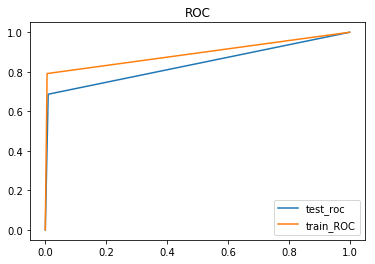

Probability density for train


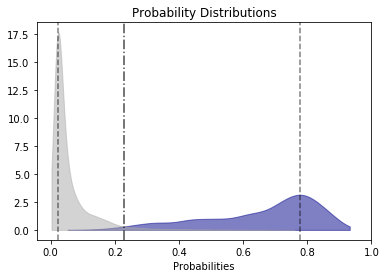

Probability density for test


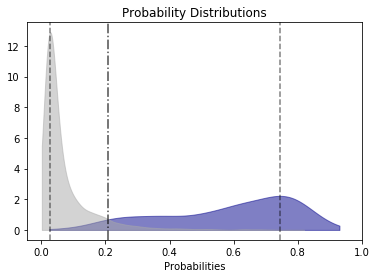


[[5824   56]
 [ 317  694]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          5824   56  5880
1           317  694  1011
All        6141  750  6891


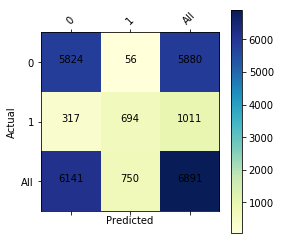


REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      5880
          1       0.93      0.69      0.79      1011

avg / total       0.94      0.95      0.94      6891

ACCURACY =  0.9458714264983311
-----------------
TEST_GROUPS Counter({'4v9f.cif1_0': 1152, '4ioa.cif1_X': 993, '5mrc.cif1_A': 833, '6d9j.cif1_5': 726, '5ool.cif1_A': 571, '3j7a.cif1_A': 489, '5xyi.cif1_2': 428, '6d9j.cif1_2': 381, '1u6b.cif1_B': 76, '5fdv.cif1_1B': 72, '3igi.cif1_A': 63, '4gxy.cif1_A': 55, '5xy3.cif1_3': 53, '3mxh.cif1_R': 46, '4r4v.cif1_A': 44, '6ha1.cif1_B': 42, '4qk8.cif1_A': 37, '3ndb.cif1_M': 33, '6d9j.cif1_7': 33, '4prf.cif1_B': 32, '5e6m.cif1_C': 32, '3u4m.cif1_B': 30, '4mgn.cif1_A': 29, '6eri.cif1_AB': 27, '2qus.cif1_A': 26, '1fir.cif1_A': 25, '2csx.cif1_C': 25, '3kfu.cif1_L': 25, '1u0b.cif1_A': 24, '5mgp.cif1_x': 24, '3ski.cif1_A': 23, '5axm.cif1_P': 23, '2xdb.cif1_G': 22, '4gcw.cif1_B': 21, '5xy3.cif1_4': 21, '3g9c.cif1_Q': 20, '5aox.cif1_C

CONFUSION MATRIX By chain:  5mgp.cif1_x
[[20  0]
 [ 0  4]]

112 A.U.8.A.A.13.A.A.22. -_tSH_- 8.92_9.77_11.56 PROBA:  0.6396895022116502
111 A.U.8.A.A.14.A.A.46. tWH_t.W_cSW 9.73_13.43_5.66 PROBA:  0.3709596333472516
CONFUSION MATRIX By chain:  1u0b.cif1_A
[[19  1]
 [ 1  3]]

110 0.A.463.0.A.477.0.A.2437. tHH_-_- 11.16_89.59_87.23 PROBA:  0.5848354001684511
110 0.G.1327.0.G.2696.0.A.2699. -_tSH_- 116.47_9.24_117.98 PROBA:  0.5733732602918176
112 0.U.2726.0.G.2731.0.C.2751. -_cWW_- 18.4_10.63_13.43 PROBA:  0.597133310701828
112 0.A.532.0.C.2088.0.G.2660. -_-_t.S 19.38_14.64_8.29 PROBA:  0.5466403889412268
111 0.C.36.0.G.446.0.A.674. cWW_-_cSW 10.71_12.14_9.51 PROBA:  0.4081108519509408
111 0.G.51.0.C.110.0.U.121. cWW_-_tSW 10.56_6.05_8.65 PROBA:  0.47078861258786275
111 0.G.157.0.C.179.0.A.1470. cWW_-_cSW 10.74_12.57_5.72 PROBA:  0.293602090551768
111 0.A.193.0.G.413.0.C.427. t.S_cWW_- 8.2_10.54_5.63 PROBA:  0.4188327588689513
111 0.A.198.0.G.416.0.C.424. tWS_cWW_- 9.53_10.77_10.44 PROBA

112 A.U.136.A.G.264.A.U.297. -_-_- 23.46_6.82_24.97 PROBA:  0.7385700178762845
112 A.U.1394.A.U.1407.A.A.1424. -_-_cWW 16.48_12.0_10.51 PROBA:  0.7165029825960858
111 A.A.11.A.A.1244.A.A.1402. cWW_tSW_cWS 12.05_8.99_5.59 PROBA:  0.051798436752884765
111 A.U.32.A.A.474.A.A.601. tWH_cWS_- 9.64_9.18_8.43 PROBA:  0.2804041223927308
111 A.A.47.A.U.100.A.A.391. cHS_cWW_- 7.7_10.55_12.08 PROBA:  0.42712944086115023
111 A.A.61.A.C.270.A.G.292. cWS_cWW_tW. 6.17_10.96_12.89 PROBA:  0.3981846193391986
111 A.A.62.A.A.269.A.U.293. -_cWW_tWS 5.66_10.38_8.49 PROBA:  0.3885771286816595
111 A.A.110.A.U.312.A.A.857. cWW_tSH_- 10.32_10.12_9.25 PROBA:  0.23136968554943807
111 A.U.115.A.G.307.A.U.340. cWW_tSW_- 10.2_9.28_9.18 PROBA:  0.319957740709113
111 A.U.168.A.C.268.A.G.294. -_cWW_tHW 5.19_10.54_11.05 PROBA:  0.2902409429074027
111 A.G.369.A.C.387.A.A.805. cWW_cSW_c.H 10.68_8.73_12.99 PROBA:  0.36736965354001816
111 A.G.370.A.G.383.A.A.806. tHS_-_tSW 10.31_18.67_9.66 PROBA:  0.3243493267436285
111 A.A

110 A.A.2377.A.U.2439.A.G.2609. -_cWW_- 40.74_11.89_33.94 PROBA:  0.6710886601252966
111 A.G.112.A.C.146.A.A.157. cWW_-_tSS 10.8_5.79_8.25 PROBA:  0.3693707790933243
111 A.G.227.A.C.249.A.A.1386. cWW_-_cSW 10.78_12.96_6.82 PROBA:  0.3416952262522513
111 A.A.231.A.A.244.A.G.587. tHH_-_cSS 10.97_16.54_5.81 PROBA:  0.10030228357530872
111 A.A.263.A.G.345.A.C.357. t.S_cWW_- 8.24_10.46_5.62 PROBA:  0.4176735030069164
111 A.C.268.A.U.348.A.A.354. -_cHW_cWS 16.38_12.92_7.84 PROBA:  0.2552319186594703
111 A.C.268.A.A.353.A.U.2674. -_cWW_cHS 11.97_10.7_8.18 PROBA:  0.3893828235269581
111 A.U.286.A.G.292.A.A.327. cWW_tSW_- 10.4_8.53_7.92 PROBA:  0.3415651047343156
111 A.A.396.A.C.592.A.G.685. cSS_cWW_- 5.64_10.78_13.23 PROBA:  0.39119301277070717
111 A.A.429.A.A.1919.A.G.1935. -_cWW_cWW 9.76_12.69_11.26 PROBA:  0.4081887983594488
111 A.A.520.A.C.2668.A.G.2682. -_cWW_cWS 12.75_10.59_5.85 PROBA:  0.21767318247721362
111 A.A.608.A.G.624.A.G.1585. tHS_-_cWS 9.47_9.93_5.53 PROBA:  0.32924256684189923

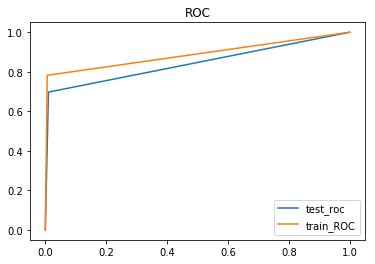

Probability density for train


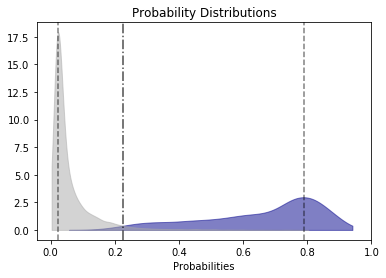

Probability density for test


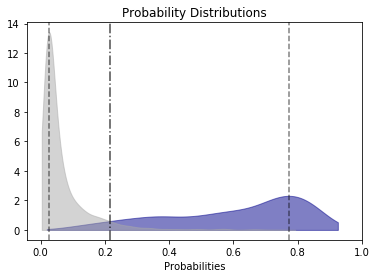


[[5816   61]
 [ 307  707]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          5816   61  5877
1           307  707  1014
All        6123  768  6891


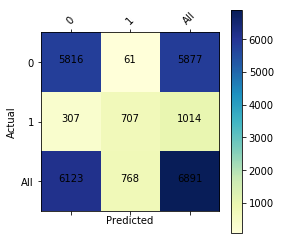


REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      5877
          1       0.92      0.70      0.79      1014

avg / total       0.95      0.95      0.94      6891

ACCURACY =  0.9465970105935277
-----------------
TEST_GROUPS Counter({'4y4o.cif1_2A': 1113, '6eri.cif1_AA': 1012, '5tbw.cif1_1': 936, '4v88.cif1_A6': 637, '5o5j.cif1_A': 574, '6gaw.cif1_BA': 539, '6az3.cif1_1': 397, '3j9m.cif1_AA': 320, '5oql.cif1_1': 156, '1nbs.cif1_B': 65, '2a64.cif1_A': 62, '5j7l.cif1_DB': 55, '6ek0.cif1_L7': 50, '6az3.cif1_8': 46, '4kqy.cif1_A': 43, '6d90.cif1_4': 40, '5lys.cif1_B': 34, '5t83.cif1_A': 33, '5wt1.cif1_C': 33, '4yye.cif1_C': 32, '1h4s.cif1_T': 31, '4lck.cif1_F': 30, '5tbw.cif1_4': 27, '2du3.cif1_D': 26, '4p5j.cif1_A': 26, '6az3.cif1_5': 25, '6ck5.cif1_A': 25, '2gdi.cif1_X': 24, '4qei.cif1_C': 24, '5o2r.cif1_x': 24, '2azx.cif1_D': 23, '5d8h.cif1_A': 23, '5ns3.cif1_C': 22, '6ek0.cif1_L8': 21, '1n78.cif1_C': 20, '3w3s.cif1_B': 20, '4lx

CONFUSION MATRIX By chain:  3rw6.cif1_H
[[6 0]
 [0 2]]

111 D.U.908.D.A.914.D.A.946. tWH_t.W_- 10.42_13.67_6.23 PROBA:  0.3404977782028458
111 D.G.916.D.U.920.D.A.958. -_cHW_tSS 10.53_12.84_8.63 PROBA:  0.2322784417836707
CONFUSION MATRIX By chain:  2du3.cif1_D
[[22  0]
 [ 2  2]]

111 P.U.8.P.A.14.P.A.46. tWH_t.W_cSW 10.08_13.68_5.75 PROBA:  0.18416026394768528
CONFUSION MATRIX By chain:  5x6b.cif1_P
[[2 0]
 [1 0]]

110 A.G.1197.A.G.1199.A.U.1200. -_cSH_- 4.15_7.18_9.15 PROBA:  0.5924123044980734
120 A.U.1193.A.A.1194.A.U.1200. -_-_- 6.79_22.53_22.77 PROBA:  0.6023687269421222
CONFUSION MATRIX By chain:  5d8h.cif1_A
[[17  2]
 [ 0  4]]

123 C.U.9.C.C.13.C.A.22. -_-_- 16.34_8.18_19.12 PROBA:  0.5070160902352747
112 C.C.13.C.A.22.C.G.47. -_-_- 8.18_14.07_14.28 PROBA:  0.5323983479600137
111 C.U.12.C.A.22.C.A.46. cWW_tHW_- 10.76_12.34_13.96 PROBA:  0.44600222303914633
CONFUSION MATRIX By chain:  5ud5.cif1_C
[[13  2]
 [ 1  2]]

110 B.U.189.B.G.217.B.G.219. cHW_-_- 11.11_10.5_13.34 PROBA:  0

112 A.A.8.A.G.36.A.A.38. tHS_-_- 8.45_12.31_5.41 PROBA:  0.7123251847981719
111 A.A.8.A.G.31.A.G.36. -_tHW_tHS 13.26_11.14_8.45 PROBA:  0.25682406869438623
CONFUSION MATRIX By chain:  3e5c.cif1_A
[[7 1]
 [1 1]]

111 A.A.55.A.A.99.A.U.393. -_cSS_cWW 10.75_5.58_10.19 PROBA:  0.26900376201891796
111 A.C.62.A.U.81.A.G.250. -_cWH_cWW 14.93_6.56_10.76 PROBA:  0.20584810835769204
111 A.U.70.A.A.74.A.A.290. tWH_cWS_- 10.64_8.74_9.48 PROBA:  0.2024955028731551
111 A.G.71.A.A.291.A.A.295. tSW_tHW_- 10.42_12.75_6.36 PROBA:  0.4968769850830374
CONFUSION MATRIX By chain:  2a64.cif1_A
[[53  0]
 [ 4  5]]

110 8.G.77.8.A.102.8.C.104. -_-_- 10.53_11.02_18.21 PROBA:  0.8338381237741508
120 8.A.29.8.A.51.8.G.53. -_-_- 13.67_9.4_13.25 PROBA:  0.6799963484437056
CONFUSION MATRIX By chain:  6az3.cif1_8
[[36  2]
 [ 0  8]]

111 A.G.7.A.C.22.A.C.48. -_tWH_cWW 12.53_10.07_10.69 PROBA:  0.4916040912777453
120 A.C.22.A.C.23.A.U.42. -_-_- 7.17_13.58_18.54 PROBA:  0.5204602806781182
CONFUSION MATRIX By chain:  5tpy

CONFUSION MATRIX By chain:  5ah5.cif1_D
[[7 0]
 [0 2]]

111 B.U.19.B.U.24.B.A.46. -_cWW_tWH 12.06_10.4_9.59 PROBA:  0.21899044394972939
CONFUSION MATRIX By chain:  2quw.cif1_B
[[0 0]
 [1 0]]

110 C.G.12.C.U.25.C.G.45. -_cWW_- 7.72_12.7_14.33 PROBA:  0.5052675976876705
111 C.U.13.C.U.22.C.A.46. cWW_tHW_- 8.86_12.24_11.75 PROBA:  0.252949083561968
CONFUSION MATRIX By chain:  4qei.cif1_C
[[19  1]
 [ 1  3]]

111 5.A.14.5.A.19.5.G.106. cSW_-_cHH 9.4_21.16_13.32 PROBA:  0.18796558658433632
CONFUSION MATRIX By chain:  6az3.cif1_5
[[21  0]
 [ 1  3]]

111 A.A.12.A.G.44.A.C.80. cSS_cWW_tWS 5.58_10.23_8.47 PROBA:  0.1958707089064923
111 A.A.24.A.U.85.A.A.109. -_cWW_cWS 10.64_10.67_9.62 PROBA:  0.047735429877319005
111 A.C.45.A.A.75.A.G.79. -_cWH_cWW 13.14_13.18_10.37 PROBA:  0.29905185365109055
0 A.C.17.A.G.38.A.G.107. cWW_-_- 10.85_36.31_46.16 PROBA:  0.5482179835019781
CONFUSION MATRIX By chain:  4kqy.cif1_A
[[35  1]
 [ 3  4]]

CONFUSION MATRIX By chain:  5xtm.cif1_D
[[3 0]
 [0 1]]

110 2A.A.84

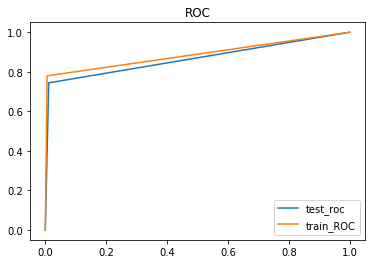

Probability density for train


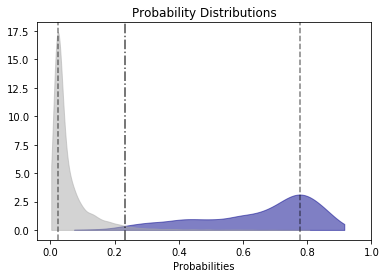

Probability density for test


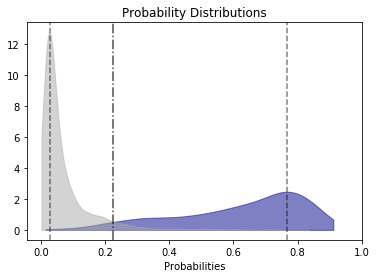


[[5805   66]
 [ 261  759]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          5805   66  5871
1           261  759  1020
All        6066  825  6891


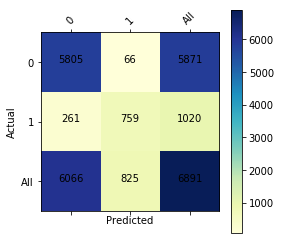


REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      5871
          1       0.92      0.74      0.82      1020

avg / total       0.95      0.95      0.95      6891

ACCURACY =  0.9525468001741402
-----------------
TEST_GROUPS Counter({'5j7l.cif1_DA': 1101, '6ha1.cif1_A': 1026, '5xxb.cif1_1': 845, '5xy3.cif1_1': 762, '6ek0.cif1_S2': 546, '5xxu.cif1_2': 473, '5ngm.cif1_Aa': 462, '5t5h.cif1_B': 287, '6gaz.cif1_AA': 275, '4wf9.cif1_Y': 57, '5t5h.cif1_D': 53, '3ivk.cif1_M': 48, '5xym.cif1_B': 45, '4plx.cif1_A': 42, '4ycp.cif1_B': 38, '1c0a.cif1_B': 34, '4y1j.cif1_A': 33, '4rdx.cif1_C': 32, '3f2x.cif1_X': 31, '4wj4.cif1_B': 31, '1j1u.cif1_B': 28, '5ccb.cif1_N': 27, '3j79.cif1_C': 26, '5hr7.cif1_D': 26, '1evv.cif1_A': 25, '2d6f.cif1_F': 24, '6cb3.cif1_B': 24, '6d9j.cif1_8': 24, '1gax.cif1_D': 23, '3al0.cif1_E': 23, '5ool.cif1_B': 23, '1hc8.cif1_C': 21, '6az3.cif1_7': 21, '4jrc.cif1_B': 20, '6az3.cif1_3': 20, '3d0u.cif1_A': 19, '3ivn.ci

111 Aa.G.148.Aa.A.174.Aa.A.1456. cWW_-_cSW 12.9_15.77_6.0 PROBA:  0.1964325171447226
111 Aa.A.160.Aa.U.351.Aa.G.354. -_tSH_cHW 10.47_9.33_10.64 PROBA:  0.322119119248395
111 Aa.G.216.Aa.C.223.Aa.A.474. cWW_c.H_- 11.89_9.29_13.94 PROBA:  0.1453473585747072
111 Aa.C.299.Aa.G.317.Aa.A.615. cWW_cSW_- 10.85_9.78_12.93 PROBA:  0.3114322408858023
111 Aa.G.305.Aa.A.308.Aa.U.573. tSH_cSW_- 9.37_6.53_14.4 PROBA:  0.40574815356728927
111 Aa.G.326.Aa.C.343.Aa.A.1443. cWW_cSS_- 10.7_5.9_12.8 PROBA:  0.29305097310266404
111 Aa.U.606.Aa.A.649.Aa.A.650. cWW_cSH_c.W 10.17_6.25_10.52 PROBA:  0.37735683344131893
111 Aa.A.774.Aa.C.1521.Aa.G.1536. -_cWW_cWS 12.87_10.78_6.78 PROBA:  0.27598858675672466
111 Aa.C.957.Aa.G.1243.Aa.U.1374. cWW_cSS_- 10.65_7.05_9.13 PROBA:  0.40440149654665375
111 Aa.A.1066.Aa.C.1210.Aa.U.1215. tHW_tWW_cWW 10.93_8.65_11.05 PROBA:  0.49219405701762226
111 Aa.G.1265.Aa.C.1269.Aa.G.1286. cSS_cWW_- 4.47_11.37_13.58 PROBA:  0.21156779640416526
CONFUSION MATRIX By chain:  5ngm.cif1_Aa

112 A.G.493.A.A.496.A.A.518. -_-_- 6.45_16.26_19.1 PROBA:  0.7819528700846581
112 A.A.2083.A.U.2104.A.U.2644. -_-_cWW 56.05_61.02_10.88 PROBA:  0.6066895803635763
111 A.A.38.A.U.488.A.A.659. cWW_cSH_- 10.67_8.54_13.0 PROBA:  0.35828641380750986
111 A.C.39.A.G.487.A.A.659. cWW_-_cSW 10.72_11.15_9.09 PROBA:  0.3749621972080409
111 A.A.65.A.U.89.A.C.503. cWW_-_cSW 10.51_11.02_7.81 PROBA:  0.09011757730592418
111 A.G.80.A.C.105.A.A.337. cWW_-_tSS 10.57_6.14_8.12 PROBA:  0.20284520026016778
111 A.A.139.A.C.1447.A.G.1639. -_cWW_tWS 9.76_10.45_10.68 PROBA:  0.22105540877346538
111 A.A.194.A.A.207.A.G.846. tHH_-_tSS 10.88_11.83_8.17 PROBA:  0.13609383386116503
111 A.A.230.A.G.457.A.C.464. tWS_cWW_- 9.35_10.88_10.77 PROBA:  0.4170286978690503
111 A.G.248.A.C.256.A.A.431. cWW_-_tSS 10.83_7.34_7.93 PROBA:  0.2456181516242737
111 A.C.249.A.G.255.A.G.433. cWW_tW._- 10.82_12.7_7.74 PROBA:  0.3756677374592957
111 A.A.490.A.C.1241.A.G.1285. -_cWW_tSS 5.54_10.3_8.37 PROBA:  0.365462018772409
111 A.C.58

111 1.G.959.1.C.980.1.A.2437. cWW_cSW_t.W 10.52_6.15_11.89 PROBA:  0.4396969661539644
111 1.U.969.1.A.1543.1.A.2470. -_tHH_cWS 15.8_11.17_5.98 PROBA:  0.3931257525075656
111 1.G.1014.1.G.2527.1.U.2917. cSS_cWW_- 4.87_10.29_13.79 PROBA:  0.3872049420465186
111 1.A.1052.1.U.2521.1.A.2924. cHS_cWW_- 7.84_10.39_12.39 PROBA:  0.3716501093285302
111 1.U.1215.1.U.2937.1.G.2974. -_cWW_tW. 9.46_10.95_11.79 PROBA:  0.45166578927787837
111 1.A.1216.1.C.2936.1.A.2975. -_cWW_tWS 10.34_11.24_8.86 PROBA:  0.37972019541542096
111 1.A.1565.1.U.1983.1.A.2465. cWS_cWW_- 9.87_10.45_11.89 PROBA:  0.4322558541945037
111 1.U.1630.1.A.1681.1.A.1899. tWH_tWW_- 9.83_13.61_10.27 PROBA:  0.36204096158598903
111 1.U.1641.1.U.1646.1.A.2280. cWW_tWW_- 10.21_10.44_10.02 PROBA:  0.40468573578465206
111 1.A.1741.1.G.1910.1.U.2671. tHS_-_cWW 9.1_9.9_10.21 PROBA:  0.20506406143334072
111 1.C.1743.1.G.1908.1.U.2670. cWW_-_cSW 10.81_11.35_6.25 PROBA:  0.3438495364045822
111 1.G.1756.1.U.1823.1.A.1889. cSW_-_cWW 8.24_14.47_

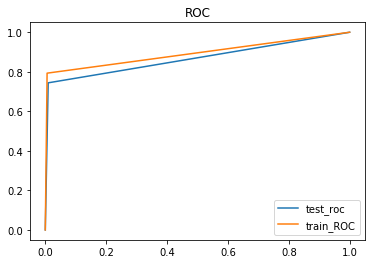

Probability density for train


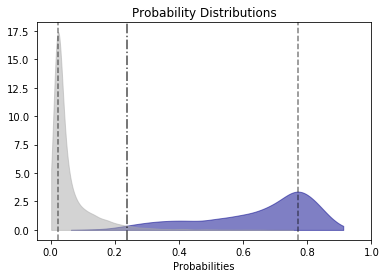

Probability density for test


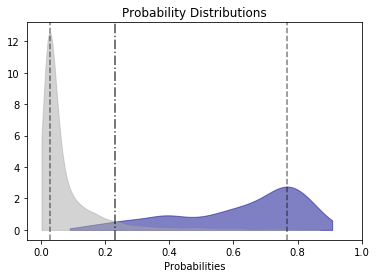


[[5819   56]
 [ 260  756]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          5819   56  5875
1           260  756  1016
All        6079  812  6891


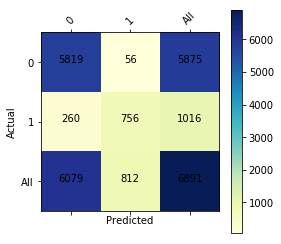


REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      5875
          1       0.93      0.74      0.83      1016

avg / total       0.95      0.95      0.95      6891

ACCURACY =  0.9541430851835728
-----------------
TEST_GROUPS Counter({'6ek0.cif1_L5': 1043, '5o60.cif1_A': 1038, '4wf9.cif1_X': 943, '5j7l.cif1_AA': 652, '4lfb.cif1_A': 588, '6eri.cif1_BA': 543, '5an9.cif1_N': 413, '6az3.cif1_2': 284, '5t2a.cif1_B': 250, '4v9f.cif1_9': 59, '3pdr.cif1_X': 54, '5xxb.cif1_3': 49, '5ml7.cif1_B': 46, '6eri.cif1_Ax': 43, '2qwy.cif1_C': 39, '1yfg.cif1_A': 35, '4aob.cif1_A': 33, '1mfq.cif1_A': 32, '4pr6.cif1_B': 32, '3hhn.cif1_E': 31, '3wqy.cif1_C': 30, '4yco.cif1_D': 27, '3amu.cif1_B': 26, '6az3.cif1_4': 26, '3q3z.cif1_V': 25, '4mgn.cif1_B': 25, '1il2.cif1_C': 24, '1qtq.cif1_B': 24, '5mrc.cif1_bb': 24, '5hr6.cif1_C': 23, '5l4o.cif1_A': 23, '3eph.cif1_E': 22, '6cfj.cif1_1x': 21, '2xd0.cif1_W': 20, '5mmm.cif1_z': 20, '5zwn.cif1_P': 20, '1b23.

112 B.U.-13.B.U.-8.B.G.-6. -_cWS_- 20.34_5.54_16.69 PROBA:  0.5708729871616873
CONFUSION MATRIX By chain:  5kk5.cif1_B
[[12  1]
 [ 0  1]]

111 B.U.8.B.A.14.B.A.20.A tWH_cWS_tSW 9.87_9.69_8.32 PROBA:  0.4731278879183609
CONFUSION MATRIX By chain:  2bte.cif1_B
[[7 0]
 [1 1]]

100 A.U.1062.A.C.1103.A.G.1106. -_-_- 38.54_15.54_25.9 PROBA:  0.5020342040298724
112 A.U.12.A.U.13.A.G.22. -_-_cWW 7.81_10.5_10.62 PROBA:  0.5293888514218221
111 A.G.41.A.C.401.A.A.621. cWW_cSS_- 10.62_5.66_12.89 PROBA:  0.4461989220769522
111 A.A.51.A.U.114.A.C.314. cHS_-_cWS 7.79_8.02_8.95 PROBA:  0.2960544941509713
111 A.C.103.A.C.150.A.A.171. -_tWH_tSW 8.96_11.45_8.9 PROBA:  0.05160759535244324
111 A.U.129.A.G.232.A.A.263. cWW_tSS_- 10.73_7.99_9.43 PROBA:  0.2840040491965253
111 A.U.173.A.G.198.A.C.219. cHS_cWW_- 5.46_10.63_11.96 PROBA:  0.2504052666162886
111 A.G.297.A.A.300.A.U.565. tSH_cSW_- 9.37_5.69_13.6 PROBA:  0.3759506915694125
111 A.G.318.A.C.335.A.A.1433. cWW_cSS_- 10.57_5.69_12.63 PROBA:  0.222221362

0 E.G.37.E.C.47.E.G.81. -_-_- 29.9_26.34_8.1 PROBA:  0.5396730989694202
CONFUSION MATRIX By chain:  3hhn.cif1_E
[[26  1]
 [ 4  0]]

110 2.G.1255.2.A.1259.2.U.1265. cWH_-_- 13.17_21.38_21.96 PROBA:  0.7314351669606012
112 2.C.776.2.G.780.2.A.814. -_-_tWW 16.2_21.66_12.37 PROBA:  0.5983623001617834
112 2.U.1266.2.G.1267.2.G.1390. cSH_-_- 6.44_37.52_36.12 PROBA:  0.8134689166215792
111 2.G.396.2.U.432.2.A.559. cWW_cSS_- 10.37_4.71_12.2 PROBA:  0.2921327312850163
111 2.A2M.527.2.A.1397.2.U.1413. -_cWW_cSS 11.2_10.17_4.46 PROBA:  0.4190307414364149
111 2.A.619.2.G.1263.2.U.1304. cSS_cWW_- 5.02_10.92_13.58 PROBA:  0.27674008961840546
111 2.G.780.2.U.811.2.U.1011. cWW_-_cSH 11.06_11.45_8.94 PROBA:  0.13324546980945182
111 2.U.1045.2.G.1051.2.C.1072. -_cWW_cSH 11.64_10.29_7.59 PROBA:  0.39132287925269826
CONFUSION MATRIX By chain:  6az3.cif1_2
[[240   3]
 [  5  36]]

110 X.A.500.X.C.2288.X.G.2306. -_cWW_- 86.02_10.48_90.6 PROBA:  0.5679859702249062
112 X.U.521.X.C.528.X.A.529. -_-_- 14.18_8.27

111 P.C.252.P.U.255.P.G.271. -_cWS_cWW 10.13_10.92_10.56 PROBA:  0.47379960161072515
111 P.C.372.P.C.373.P.G.445. cWH_-_cWW 7.1_8.82_10.46 PROBA:  0.46917177723851006
CONFUSION MATRIX By chain:  5zwn.cif1_P
[[17  0]
 [ 2  1]]

123 A.A.20.A.C.29.A.U.30. -_-_- 20.95_5.32_17.24 PROBA:  0.51917789102356
112 A.A.22.A.G.23.A.A.61. -_-_- 5.23_9.35_11.22 PROBA:  0.6389884519629515
112 A.C.29.A.U.30.A.A.61. -_cSW_- 5.32_9.28_13.73 PROBA:  0.574018219969933
111 A.A.12.A.G.43.A.C.59. cSS_cWW_- 5.59_10.65_8.61 PROBA:  0.2783236454910519
120 A.G.43.A.G.58.A.A.61. -_-_- 13.72_18.83_16.44 PROBA:  0.5955813093861722
CONFUSION MATRIX By chain:  4aob.cif1_A
[[24  4]
 [ 1  4]]

100 B.A.13.B.U.38.B.C.39. -_-_- 10.14_5.59_9.37 PROBA:  0.7627150797932639
CONFUSION MATRIX By chain:  1s03.cif1_B
[[8 1]
 [0 2]]

CONFUSION MATRIX By chain:  5ob3.cif1_A
[[2 0]
 [0 1]]

123 E.U.8.E.G.12.E.G.22. -_-_- 11.98_14.41_10.42 PROBA:  0.5661464163963678
110 E.G.12.E.C.23.E.G.27. cWW_-_- 10.74_16.03_15.32 PROBA:  0.5182420

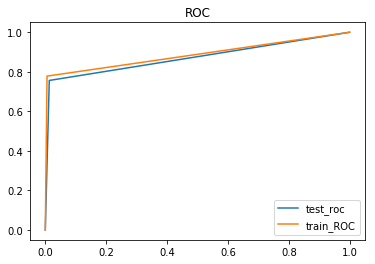

Probability density for train


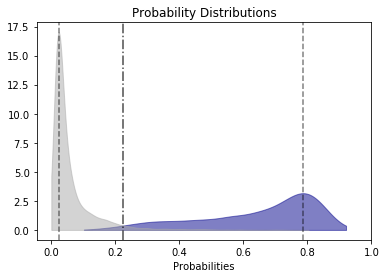

Probability density for test


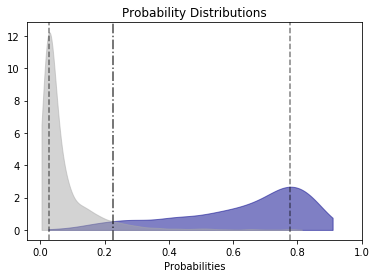


[[5801   77]
 [ 247  766]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          5801   77  5878
1           247  766  1013
All        6048  843  6891


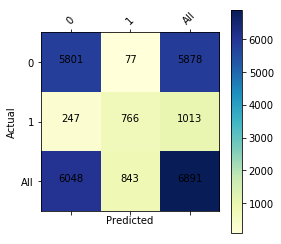


REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      5878
          1       0.91      0.76      0.83      1013

avg / total       0.95      0.95      0.95      6891

ACCURACY =  0.9529821506312581
-----------------


In [6]:
groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=5)
#group_kfold.get_n_splits(X, y, groups)

description = ['type', 'dssrs', 'bps', 'dists']

for train_index, test_index in group_kfold.split(triplexes, triplexes_target, groups):
    #triplexes_data = triplexes.iloc[:, 5:475]
    #print(triplexes_data)
    X_train_middle, X_test_middle = triplexes.loc[list(train_index)], triplexes.loc[test_index]
    X_train = X_train_middle.iloc[:, 5:475]
    X_test = X_test_middle.iloc[:, 5:475]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]

    
    a = Counter(list(triplexes.loc[list(train_index)].pdb_chain.values))
    b = Counter(list(triplexes.loc[list(test_index)].pdb_chain.values))
    
    for key in a:
        if key in b.keys():
            print("FUUUUUUUUU")
    print("TEST_GROUPS", Counter(list(triplexes.pdb_chain.loc[test_index])))
    rf_classifier_cv.fit(X_train, y_train)
    
    #prediction by chains
    chains = list(set(X_test_middle.pdb_chain.values))

    print("")
    for chain in chains:
        middle_check_test = X_test_middle.loc[X_test_middle['pdb_chain'] == chain]
        middle_target_test = middle_check_test['istriple']
        middle_check_test_ = middle_check_test.iloc[:, 5:475]
    
        prediction_result_by_chain = rf_classifier_cv.predict(middle_check_test_)
        predict_proba_by_chain = rf_classifier_cv.predict_proba(middle_check_test_)

        
        #PREDICTED PROBABILITIES
        i = 0
        for index, row in middle_check_test.iterrows():
            if middle_target_test[index] != prediction_result_by_chain[i]:
                print(row['type'], row['dssrs'], row['bps'], row['dists'], "PROBA: ", predict_proba_by_chain[i][1])
            i = i + 1

        print("CONFUSION MATRIX By chain: ", chain)
        print(confusion_matrix(middle_target_test, prediction_result_by_chain))
        print("")
    
    #simple prediction
    prediction_result = rf_classifier_cv.predict(X_test)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob_train = rf_classifier_cv.predict_proba(X_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  prediction_train)
    auc_train = metrics.roc_auc_score(y_train, prediction_train)
    print("AUC_TRAIN = ", auc_train)
    
    #---------------------------------
    print("")
    fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_result)
    auc = metrics.roc_auc_score(y_test, prediction_result)
    print("AUC = ", auc)
    line_test, = plt.plot(fpr, tpr, label='test_roc')
    line_train, = plt.plot(fpr_train, tpr_train, label='train_roc')
    plt.legend( [line_test, line_train], ['test_roc', 'train_ROC'], loc = 4)
    plt.title("ROC")
    plt.show()
    
    print("Probability density for train")
    probability_density(prediction_prob_train[:, 1], y_train)
    print("Probability density for test")
    probability_density(prediction_prob[:, 1], y_test)
    
    print("")
    print(confusion_matrix(y_test, prediction_result))
    plot_confusion_matrix(pd.crosstab(y_test, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))


    print("")
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY = ", accuracy_score(y_test, prediction_result))
    print("-----------------")



AUC_TRAIN =  0.8856001087240121

AUC =  0.8422985801043079


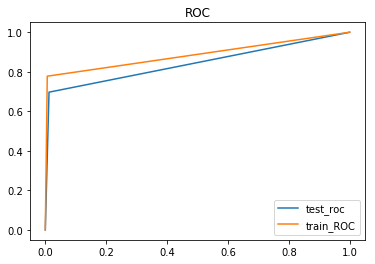

Probability density for train


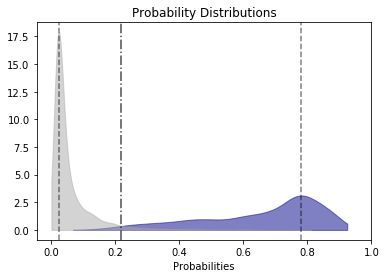

Probability density for test


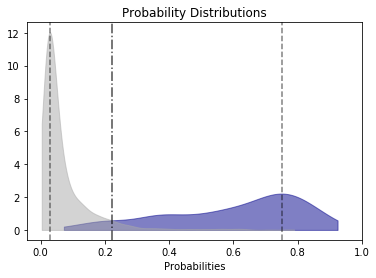


[[2902   36]
 [ 154  354]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2902   36  2938
1           154  354   508
All        3056  390  3446


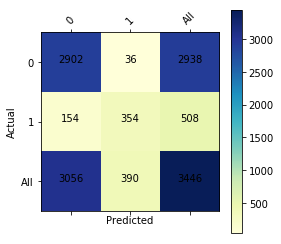

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2938
          1       0.91      0.70      0.79       508

avg / total       0.94      0.94      0.94      3446

ACCURACY 0.9448636099825886
-----------------

AUC_TRAIN =  0.8878240801224873

AUC =  0.8574027272288718


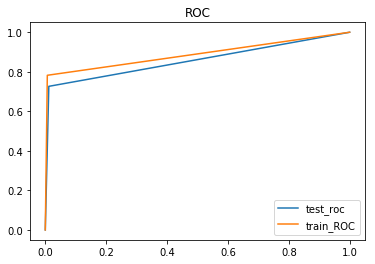

Probability density for train


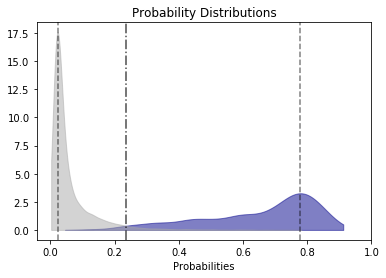

Probability density for test


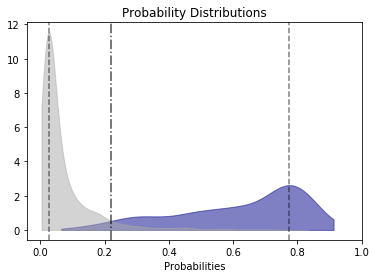


[[2904   34]
 [ 139  369]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2904   34  2938
1           139  369   508
All        3043  403  3446


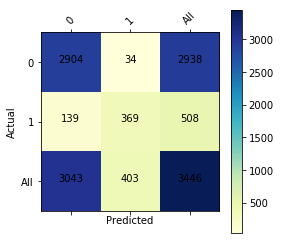

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2938
          1       0.92      0.73      0.81       508

avg / total       0.95      0.95      0.95      3446

ACCURACY 0.9497968659315148
-----------------

AUC_TRAIN =  0.8846035478687874

AUC =  0.8505129634493442


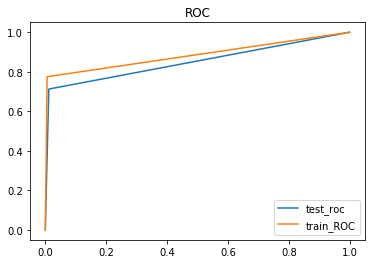

Probability density for train


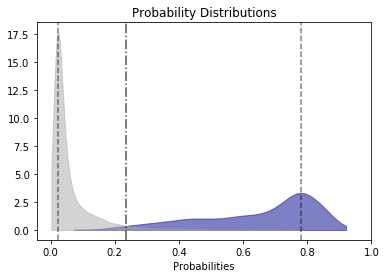

Probability density for test


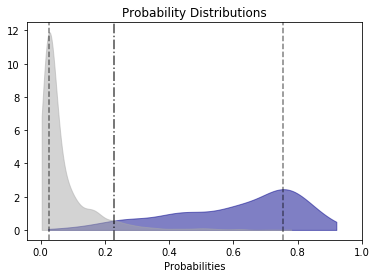


[[2904   34]
 [ 146  362]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2904   34  2938
1           146  362   508
All        3050  396  3446


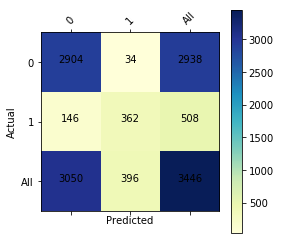

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2938
          1       0.91      0.71      0.80       508

avg / total       0.95      0.95      0.95      3446

ACCURACY 0.9477655252466628
-----------------

AUC_TRAIN =  0.8796851162728159

AUC =  0.8669496652415908


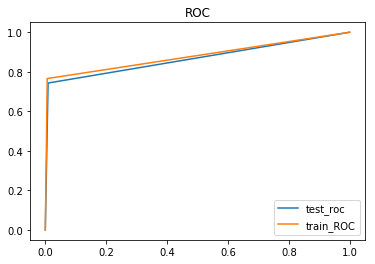

Probability density for train


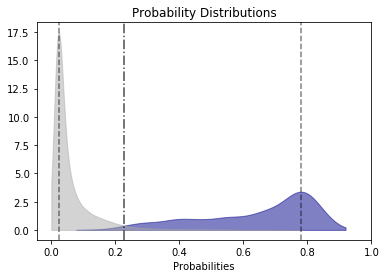

Probability density for test


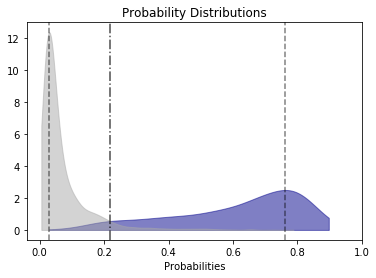


[[2913   27]
 [ 130  376]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2913   27  2940
1           130  376   506
All        3043  403  3446


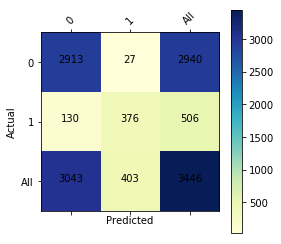

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      2940
          1       0.93      0.74      0.83       506

avg / total       0.95      0.95      0.95      3446

ACCURACY 0.9544399303540336
-----------------

AUC_TRAIN =  0.8811773928211395

AUC =  0.8514888196752778


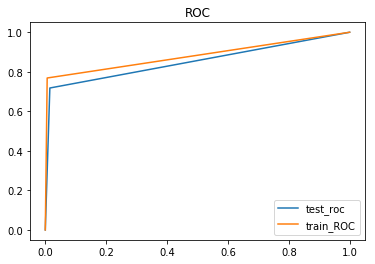

Probability density for train


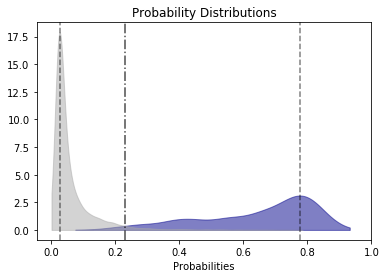

Probability density for test


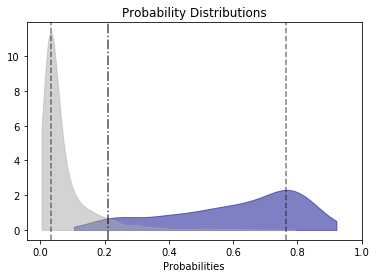


[[2895   44]
 [ 143  364]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2895   44  2939
1           143  364   507
All        3038  408  3446


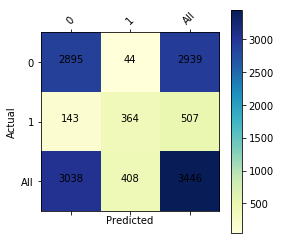

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2939
          1       0.89      0.72      0.80       507

avg / total       0.94      0.95      0.94      3446

ACCURACY 0.9457341845618108
-----------------

AUC_TRAIN =  0.8831631072535717

AUC =  0.8532579288195353


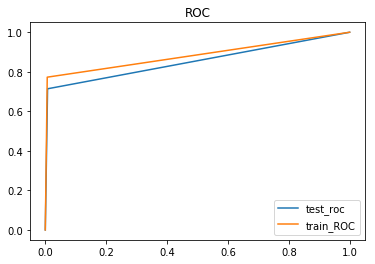

Probability density for train


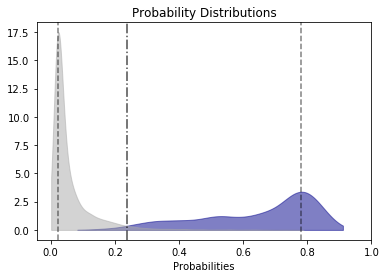

Probability density for test


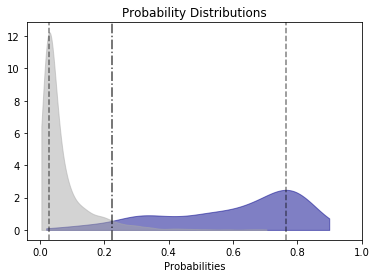


[[2916   22]
 [ 145  362]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2916   22  2938
1           145  362   507
All        3061  384  3445


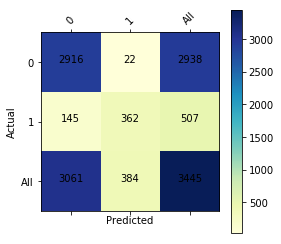

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2938
          1       0.94      0.71      0.81       507

avg / total       0.95      0.95      0.95      3445

ACCURACY 0.9515239477503629
-----------------

AUC_TRAIN =  0.8796812383605077

AUC =  0.8489588026364807


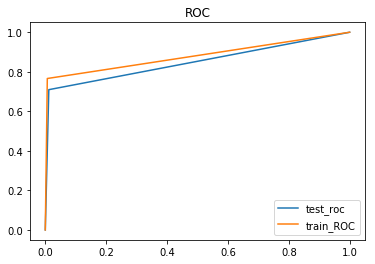

Probability density for train


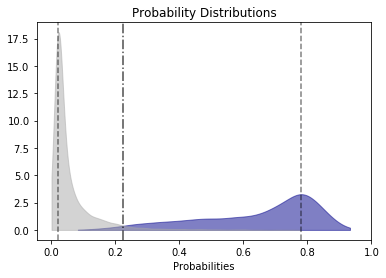

Probability density for test


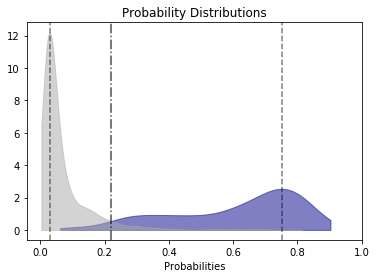


[[2905   34]
 [ 147  359]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2905   34  2939
1           147  359   506
All        3052  393  3445


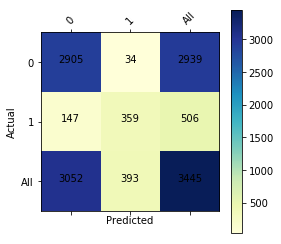

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2939
          1       0.91      0.71      0.80       506

avg / total       0.95      0.95      0.94      3445

ACCURACY 0.9474600870827286
-----------------

AUC_TRAIN =  0.8871790024894466

AUC =  0.8599171847645704


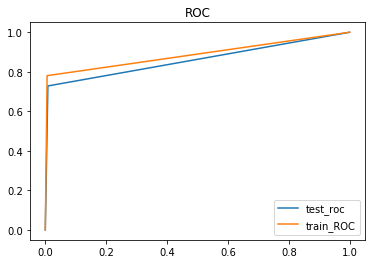

Probability density for train


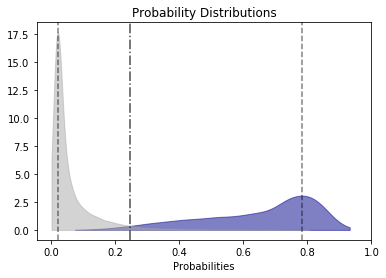

Probability density for test


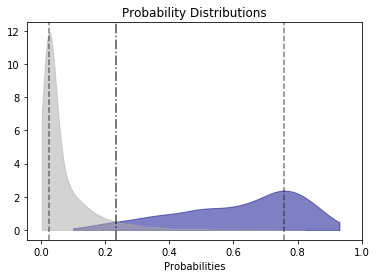


[[2912   25]
 [ 138  370]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2912   25  2937
1           138  370   508
All        3050  395  3445


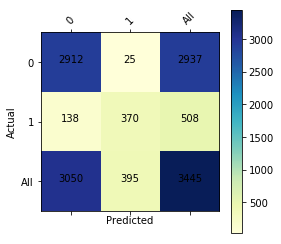

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2937
          1       0.94      0.73      0.82       508

avg / total       0.95      0.95      0.95      3445

ACCURACY 0.9526850507982584
-----------------

AUC_TRAIN =  0.8853244979945224

AUC =  0.8631360271743356


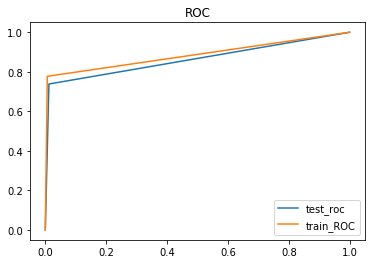

Probability density for train


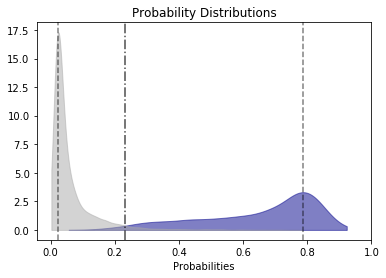

Probability density for test


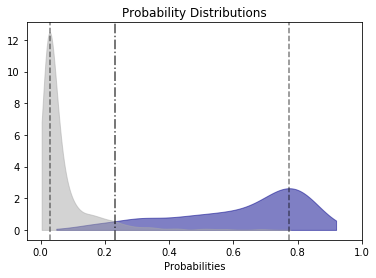


[[2902   35]
 [ 133  375]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2902   35  2937
1           133  375   508
All        3035  410  3445


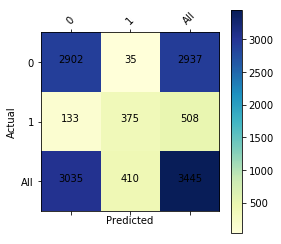

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      2937
          1       0.91      0.74      0.82       508

avg / total       0.95      0.95      0.95      3445

ACCURACY 0.9512336719883889
-----------------

AUC_TRAIN =  0.8854308641413358

AUC =  0.8616410499760053


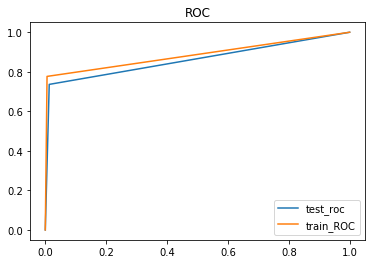

Probability density for train


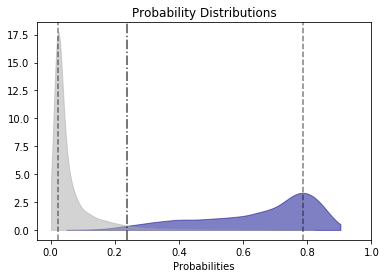

Probability density for test


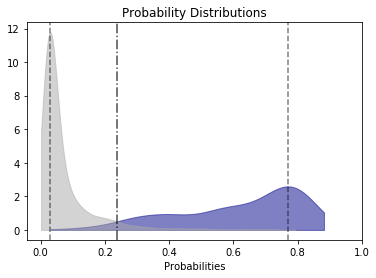


[[2899   38]
 [ 134  374]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2899   38  2937
1           134  374   508
All        3033  412  3445


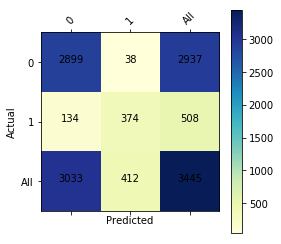

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      2937
          1       0.91      0.74      0.81       508

avg / total       0.95      0.95      0.95      3445

ACCURACY 0.9500725689404935
-----------------


In [7]:
# 10 фолдов

groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=10)
#group_kfold.get_n_splits(X, y, groups)

for train_index, test_index in group_kfold.split(triplexes_data, triplexes_target, groups):
    print("")
    X_train, X_test = triplexes_data.loc[list(train_index)], triplexes_data.loc[test_index]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]
    rf_classifier_cv.fit(X_train, y_train)
    prediction_result = rf_classifier_cv.predict(X_test)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob_train = rf_classifier_cv.predict_proba(X_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  prediction_train)
    auc_train = metrics.roc_auc_score(y_train, prediction_train)
    print("AUC_TRAIN = ", auc_train)
    
    #---------------------------------
    print("")
    fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_result)
    auc = metrics.roc_auc_score(y_test, prediction_result)
    print("AUC = ", auc)
    line_test, = plt.plot(fpr, tpr, label='test_roc')
    line_train, = plt.plot(fpr_train, tpr_train, label='train_roc')
    plt.legend( [line_test, line_train], ['test_roc', 'train_ROC'], loc = 4)
    plt.title("ROC")
    plt.show()
    
    print("Probability density for train")
    probability_density(prediction_prob_train[:, 1], y_train)
    print("Probability density for test")
    probability_density(prediction_prob[:, 1], y_test)
    
    print("")
    print(confusion_matrix(y_test, prediction_result))
    plot_confusion_matrix(pd.crosstab(y_test, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))
    
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY", accuracy_score(y_test, prediction_result))
    print("-----------------")



AUC_TRAIN =  0.8916233991099016

AUC =  0.8307893912670808


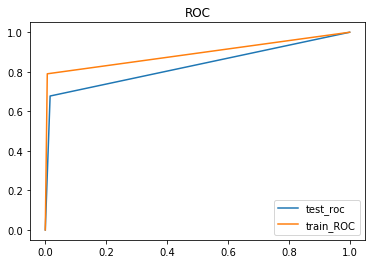

Probability density for train


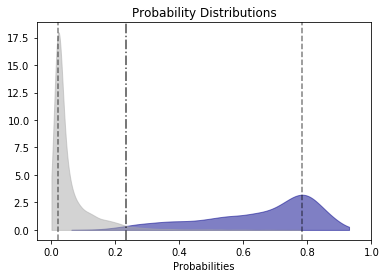

Probability density for test


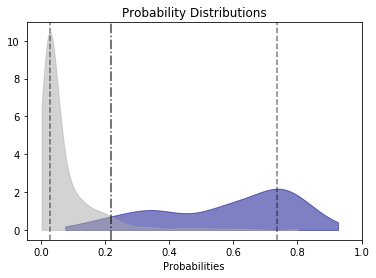


[[1926   31]
 [ 110  231]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1926   31  1957
1           110  231   341
All        2036  262  2298


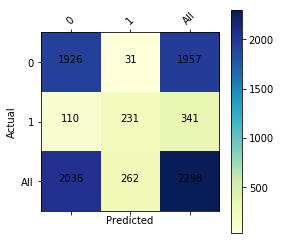

REPORT
             precision    recall  f1-score   support

          0       0.95      0.98      0.96      1957
          1       0.88      0.68      0.77       341

avg / total       0.94      0.94      0.94      2298

ACCURACY 0.9386422976501305
-----------------

AUC_TRAIN =  0.8884812486225709

AUC =  0.8496173566418671


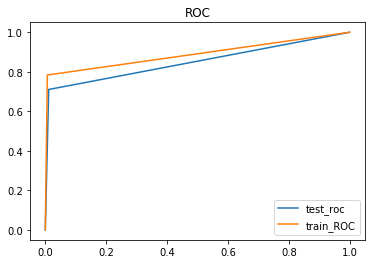

Probability density for train


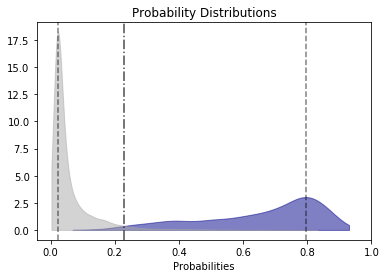

Probability density for test


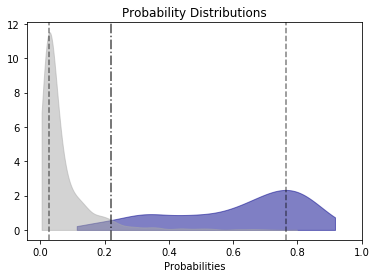


[[1940   22]
 [  97  238]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1940   22  1962
1            97  238   335
All        2037  260  2297


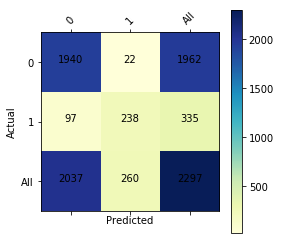

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1962
          1       0.92      0.71      0.80       335

avg / total       0.95      0.95      0.95      2297

ACCURACY 0.9481932956029604
-----------------

AUC_TRAIN =  0.8859362328660013

AUC =  0.8516524859201842


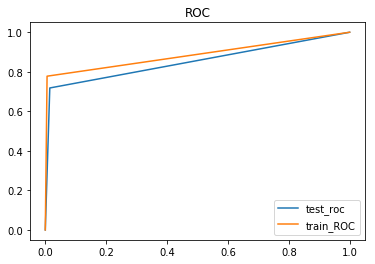

Probability density for train


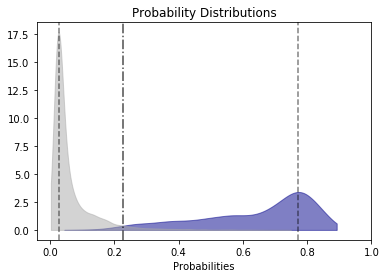

Probability density for test


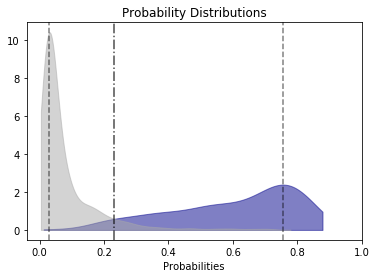


[[1931   29]
 [  95  242]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1931   29  1960
1            95  242   337
All        2026  271  2297


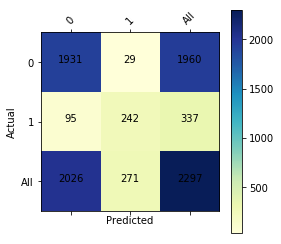

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1960
          1       0.89      0.72      0.80       337

avg / total       0.94      0.95      0.94      2297

ACCURACY 0.9460165433173705
-----------------

AUC_TRAIN =  0.8880108052089563

AUC =  0.8519075879610005


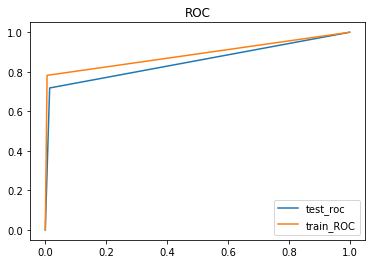

Probability density for train


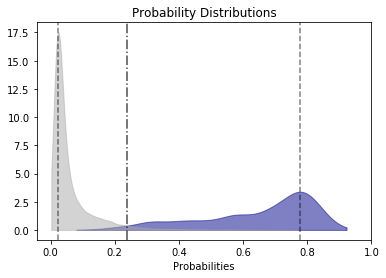

Probability density for test


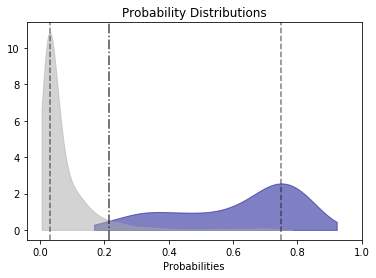


[[1932   28]
 [  95  242]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1932   28  1960
1            95  242   337
All        2027  270  2297


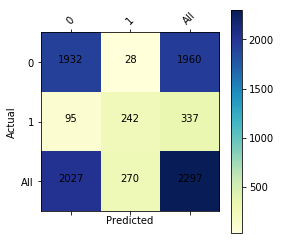

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1960
          1       0.90      0.72      0.80       337

avg / total       0.94      0.95      0.94      2297

ACCURACY 0.9464518937744885
-----------------

AUC_TRAIN =  0.8898458485302962

AUC =  0.855080090435325


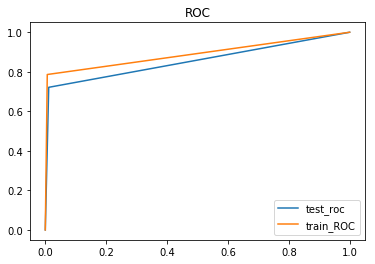

Probability density for train


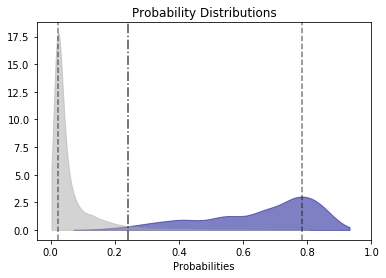

Probability density for test


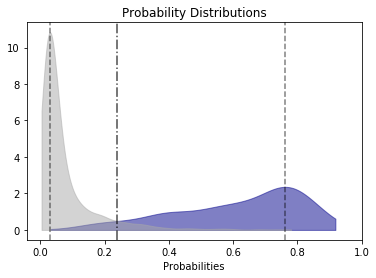


[[1934   22]
 [  95  246]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1934   22  1956
1            95  246   341
All        2029  268  2297


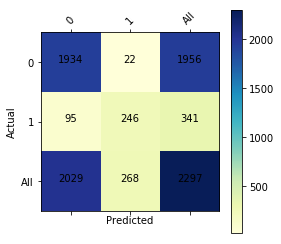

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1956
          1       0.92      0.72      0.81       341

avg / total       0.95      0.95      0.95      2297

ACCURACY 0.9490639965171963
-----------------

AUC_TRAIN =  0.8785199402248636

AUC =  0.8865152243830592


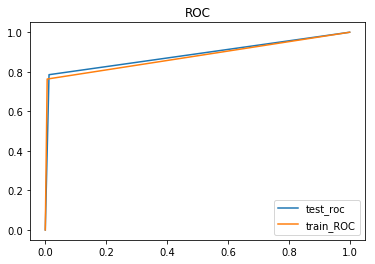

Probability density for train


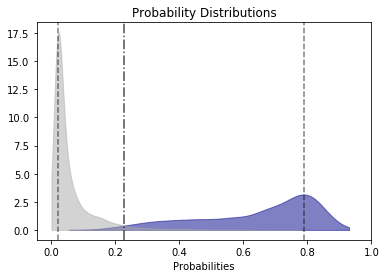

Probability density for test


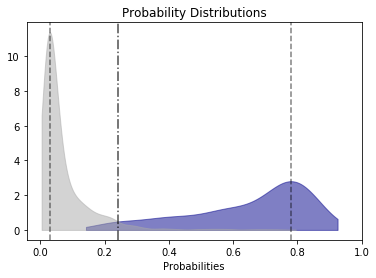


[[1933   24]
 [  73  267]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1933   24  1957
1            73  267   340
All        2006  291  2297


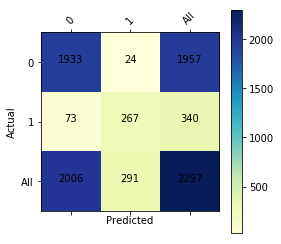

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.98      1957
          1       0.92      0.79      0.85       340

avg / total       0.96      0.96      0.96      2297

ACCURACY 0.957771005659556
-----------------

AUC_TRAIN =  0.8831257539349595

AUC =  0.858688807132677


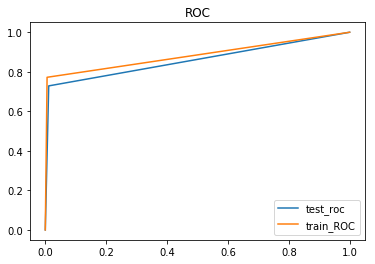

Probability density for train


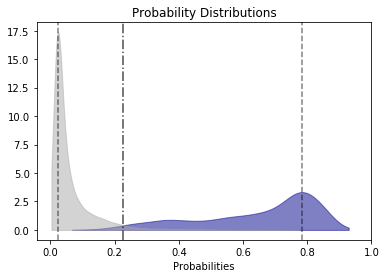

Probability density for test


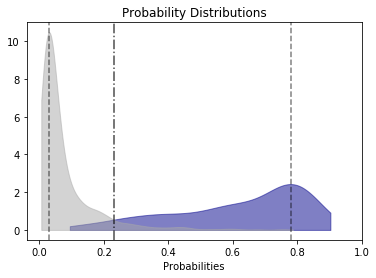


[[1936   22]
 [  92  247]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1936   22  1958
1            92  247   339
All        2028  269  2297


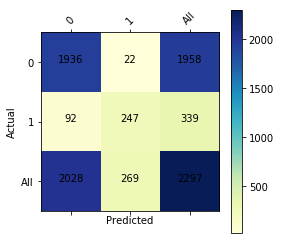

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1958
          1       0.92      0.73      0.81       339

avg / total       0.95      0.95      0.95      2297

ACCURACY 0.9503700478885503
-----------------

AUC_TRAIN =  0.8882232562781817

AUC =  0.8837625534453614


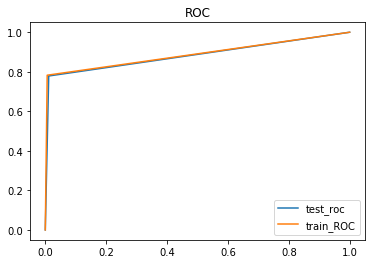

Probability density for train


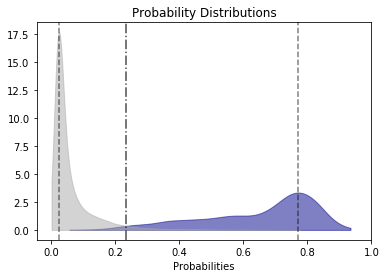

Probability density for test


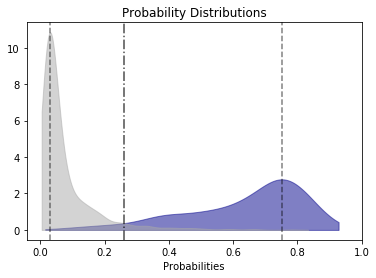


[[1936   22]
 [  75  264]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1936   22  1958
1            75  264   339
All        2011  286  2297


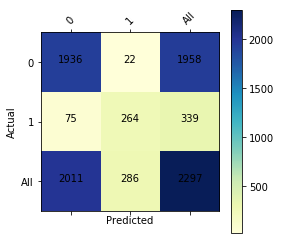

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.98      1958
          1       0.92      0.78      0.84       339

avg / total       0.96      0.96      0.96      2297

ACCURACY 0.957771005659556
-----------------

AUC_TRAIN =  0.8890271362999311

AUC =  0.847382698608314


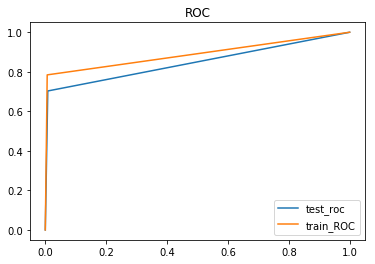

Probability density for train


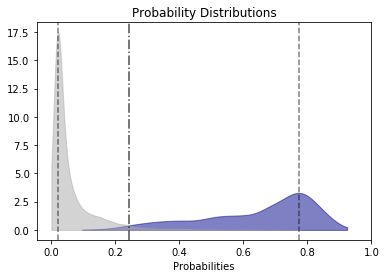

Probability density for test


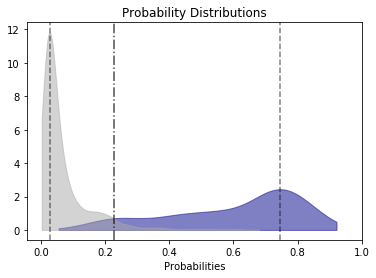


[[1941   16]
 [ 101  239]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1941   16  1957
1           101  239   340
All        2042  255  2297


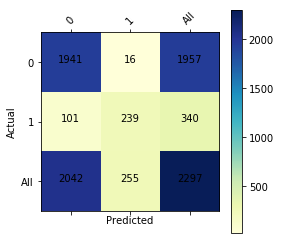

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1957
          1       0.94      0.70      0.80       340

avg / total       0.95      0.95      0.95      2297

ACCURACY 0.9490639965171963
-----------------

AUC_TRAIN =  0.8804441655274814

AUC =  0.8571703652690812


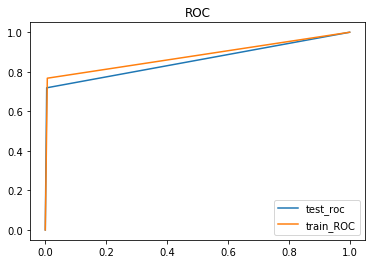

Probability density for train


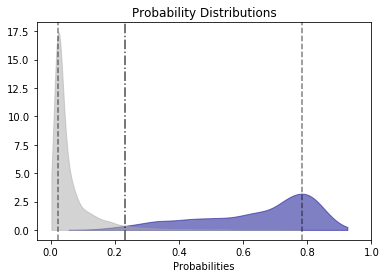

Probability density for test


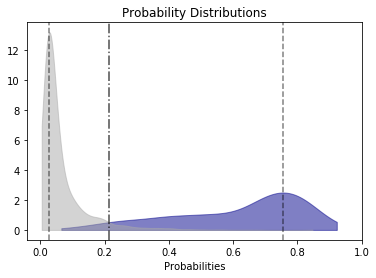


[[1950    9]
 [  95  243]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1950    9  1959
1            95  243   338
All        2045  252  2297


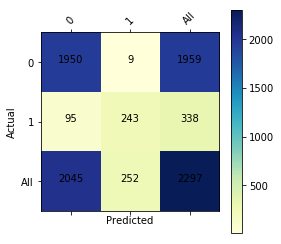

REPORT
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      1959
          1       0.96      0.72      0.82       338

avg / total       0.96      0.95      0.95      2297

ACCURACY 0.9547235524597301
-----------------

AUC_TRAIN =  0.8856157235912987

AUC =  0.8395748803972628


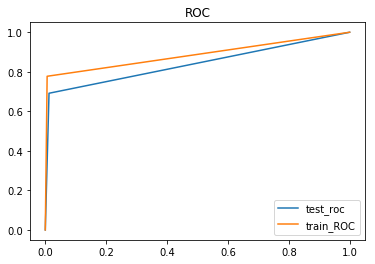

Probability density for train


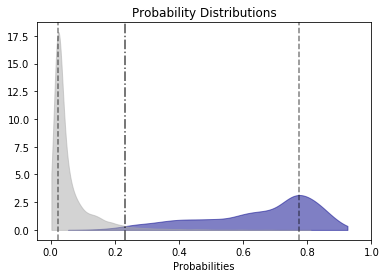

Probability density for test


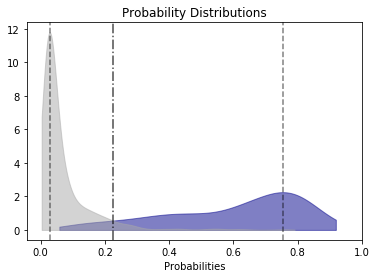


[[1936   24]
 [ 104  233]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1936   24  1960
1           104  233   337
All        2040  257  2297


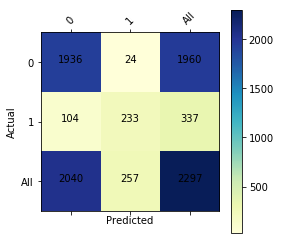

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1960
          1       0.91      0.69      0.78       337

avg / total       0.94      0.94      0.94      2297

ACCURACY 0.9442751414888986
-----------------

AUC_TRAIN =  0.8875944062840647

AUC =  0.8350799375360572


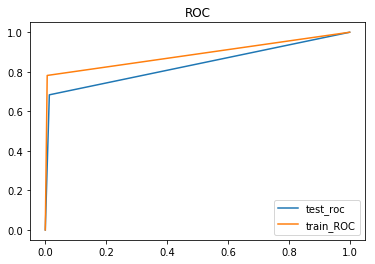

Probability density for train


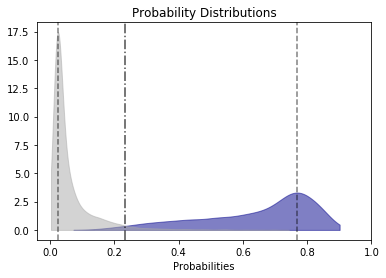

Probability density for test


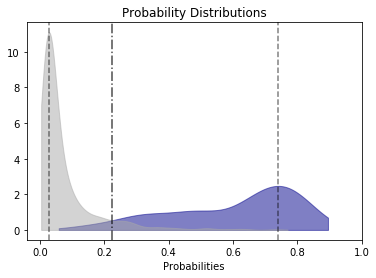


[[1933   26]
 [ 107  231]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1933   26  1959
1           107  231   338
All        2040  257  2297


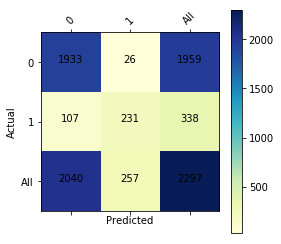

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1959
          1       0.90      0.68      0.78       338

avg / total       0.94      0.94      0.94      2297

ACCURACY 0.9420983892033087
-----------------

AUC_TRAIN =  0.8799384706847478

AUC =  0.8677266985391446


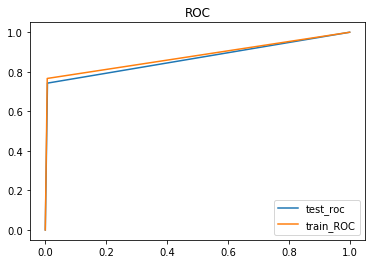

Probability density for train


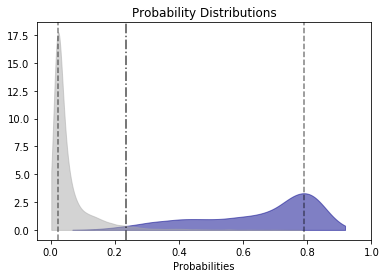

Probability density for test


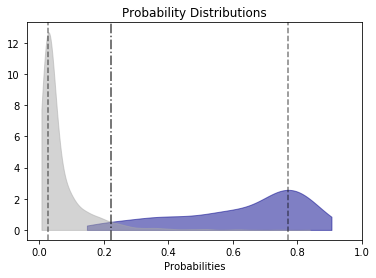


[[1944   14]
 [  87  251]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1944   14  1958
1            87  251   338
All        2031  265  2296


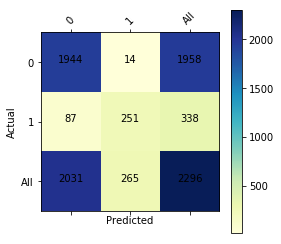

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      1958
          1       0.95      0.74      0.83       338

avg / total       0.96      0.96      0.95      2296

ACCURACY 0.9560104529616724
-----------------

AUC_TRAIN =  0.8895662761318244

AUC =  0.8424095120726642


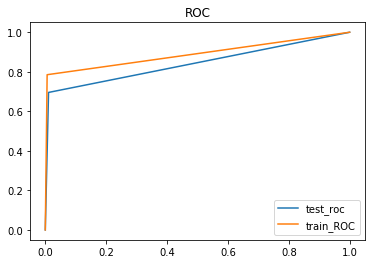

Probability density for train


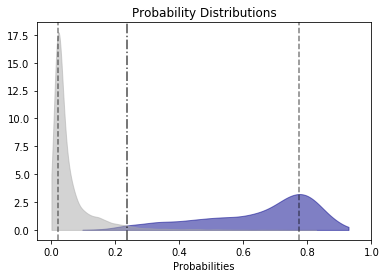

Probability density for test


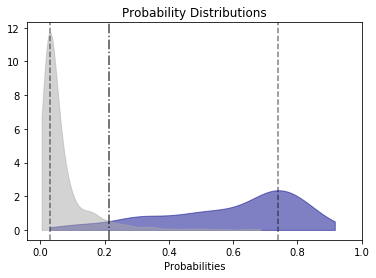


[[1941   21]
 [ 102  233]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1941   21  1962
1           102  233   335
All        2043  254  2297


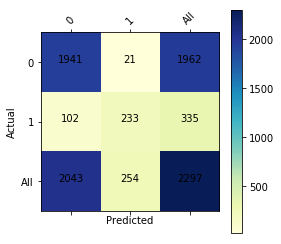

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1962
          1       0.92      0.70      0.79       335

avg / total       0.95      0.95      0.94      2297

ACCURACY 0.9464518937744885
-----------------

AUC_TRAIN =  0.8894607810576537

AUC =  0.8437414314166825


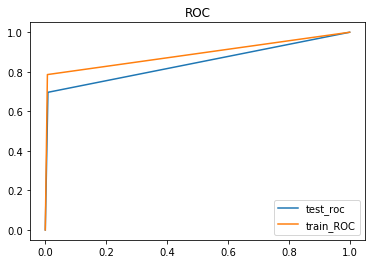

Probability density for train


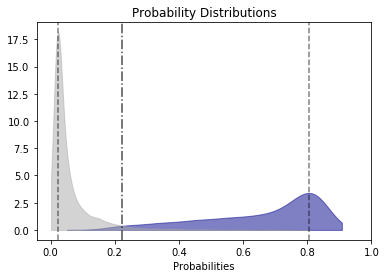

Probability density for test


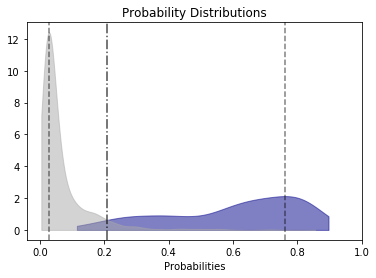


[[1941   17]
 [ 103  236]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1941   17  1958
1           103  236   339
All        2044  253  2297


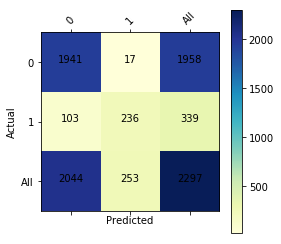

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1958
          1       0.93      0.70      0.80       339

avg / total       0.95      0.95      0.94      2297

ACCURACY 0.9477579451458424
-----------------


In [8]:
# 15 фолдов

groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=15)

for train_index, test_index in group_kfold.split(triplexes_data, triplexes_target, groups):
    print("")
    X_train, X_test = triplexes_data.loc[list(train_index)], triplexes_data.loc[test_index]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]
    rf_classifier_cv.fit(X_train, y_train)
    prediction_result = rf_classifier_cv.predict(X_test)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob_train = rf_classifier_cv.predict_proba(X_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  prediction_train)
    auc_train = metrics.roc_auc_score(y_train, prediction_train)
    print("AUC_TRAIN = ", auc_train)
    
    #---------------------------------
    print("")
    fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_result)
    auc = metrics.roc_auc_score(y_test, prediction_result)
    print("AUC = ", auc)
    line_test, = plt.plot(fpr, tpr, label='test_roc')
    line_train, = plt.plot(fpr_train, tpr_train, label='train_roc')
    plt.legend( [line_test, line_train], ['test_roc', 'train_ROC'], loc = 4)
    plt.title("ROC")
    plt.show()
    
    print("Probability density for train")
    probability_density(prediction_prob_train[:, 1], y_train)
    print("Probability density for test")
    probability_density(prediction_prob[:, 1], y_test)
    
    print("")
    print(confusion_matrix(y_test, prediction_result))
    plot_confusion_matrix(pd.crosstab(y_test, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))
    
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY", accuracy_score(y_test, prediction_result))
    print("-----------------")
